# Anomaly detection for time series

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length,plotFig
from sklearn.preprocessing import MinMaxScaler

##  Prepare data

In [2]:
# Prepare data for unsupervised method

filepath = './data/benchmark/ECG/MBA_ECG805_data.out'
df = pd.read_csv(filepath, header=None).to_numpy()

name = filepath.split('/')[-1]
max_length = 10000

data = df[:max_length,0].astype(float)
label = df[:max_length,1]
    
slidingWindow = find_length(data)
X_data = Window(window = slidingWindow).convert(data).to_numpy()


# Prepare data for semisupervised method. 
# Here, the training ratio = 0.1

data_train = data[:int(0.1*len(data))]
data_test = data

X_train = Window(window = slidingWindow).convert(data_train).to_numpy()
X_test = Window(window = slidingWindow).convert(data_test).to_numpy()

## Display the results of 10 anomaly detectors

For each output figure, the left panel shows the real time series with outliers (red), anomaly score obtained by each anomaly detector, and the correpsonding TP/FP/TN/FN classification. 

The right panel shows the ROC curve. AUC represents the area under the ROC curve. Larger AUC indicates better performance.

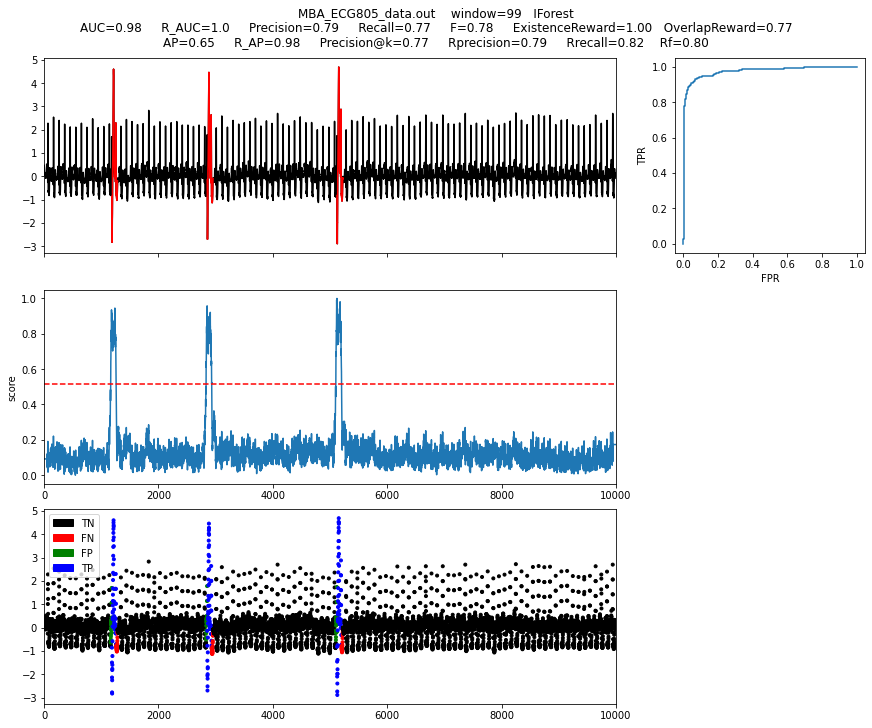

In [4]:
from TSB_UAD.models.iforest import IForest

modelName='IForest'
clf = IForest(n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 
# plt.savefig('./'+modelName+'.png')

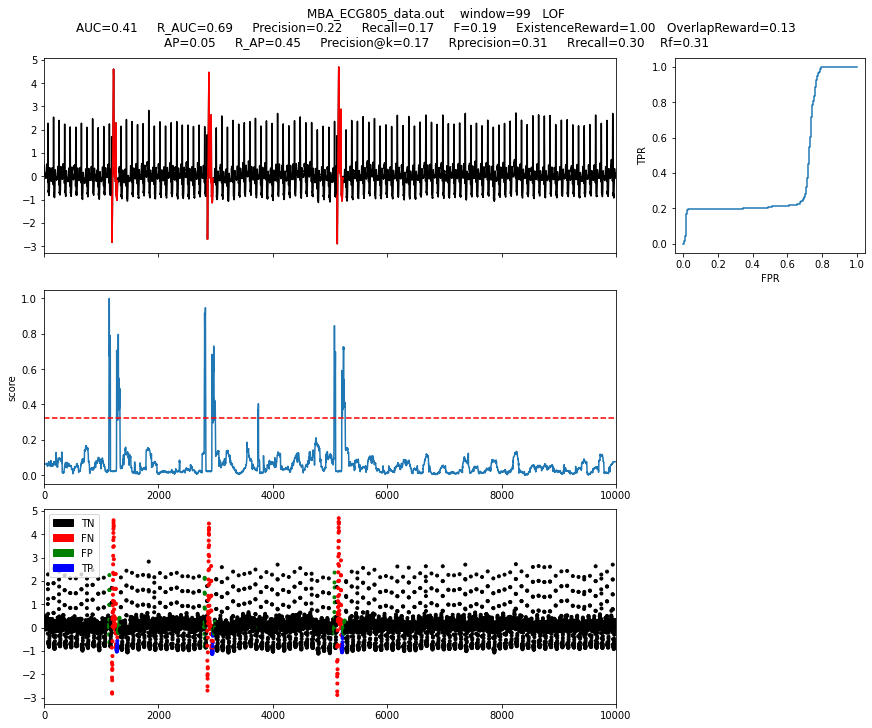

In [5]:
from TSB_UAD.models.lof import LOF

modelName='LOF'
clf = LOF(n_neighbors=20, n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 
#plt.savefig('./'+modelName+'.png')

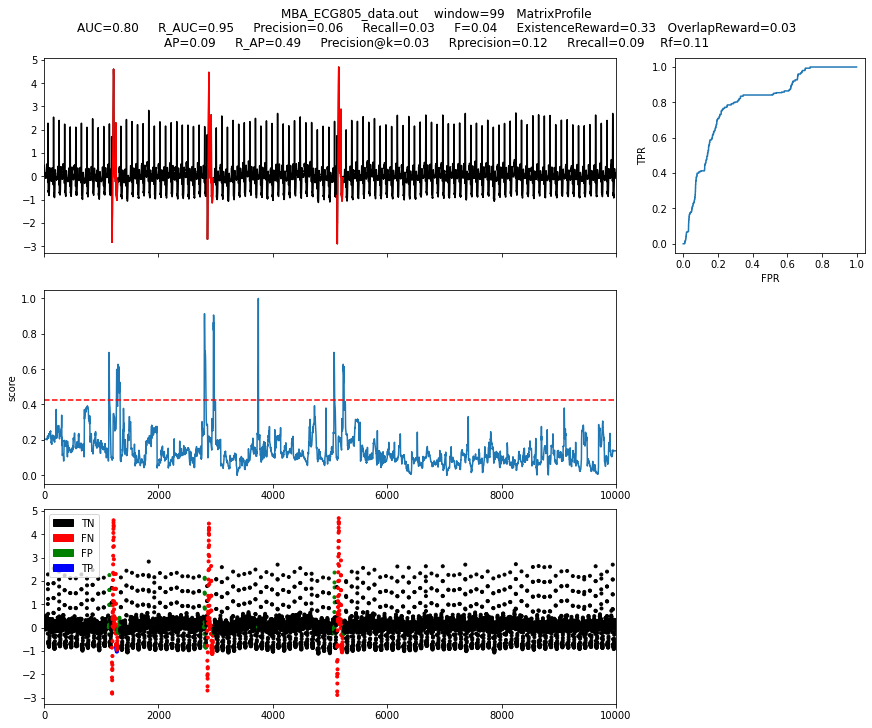

In [6]:
from TSB_UAD.models.matrix_profile import MatrixProfile

modelName='MatrixProfile'
clf = MatrixProfile(window = slidingWindow)
x = data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]
#plt.savefig('./'+modelName+'.png')

C:\Users\kymws\anaconda3\envs\TSB\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


Normal Model Length/number of subsequences selected:  (297, 10)


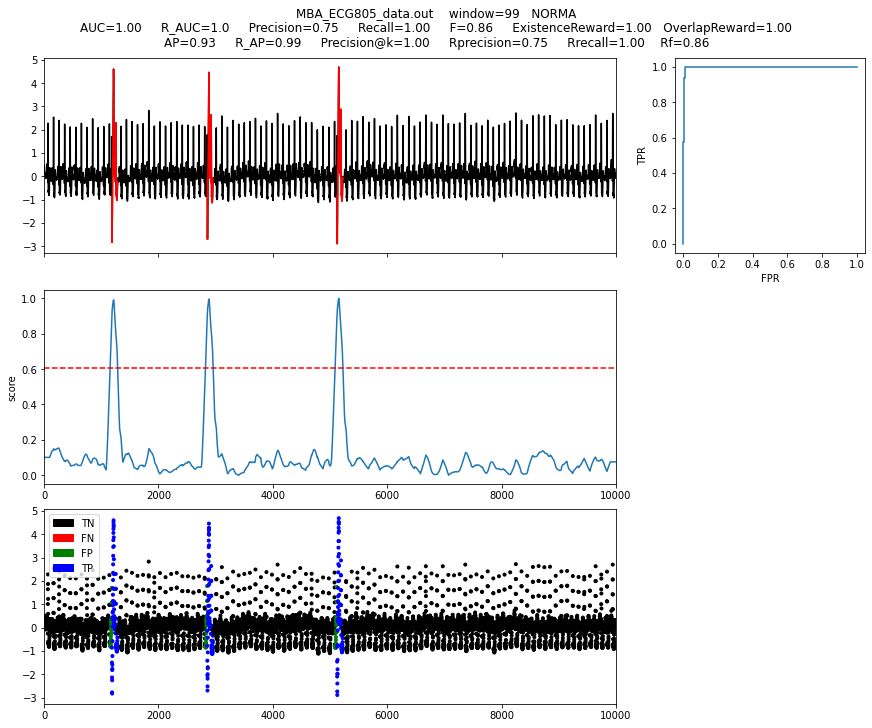

In [8]:
from TSB_UAD.models.norma import NORMA

modelName='NORMA'
clf = NORMA(pattern_length = slidingWindow, nm_size=3*slidingWindow)
x = data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*((slidingWindow-1)//2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]
#plt.savefig('./'+modelName+'.png')

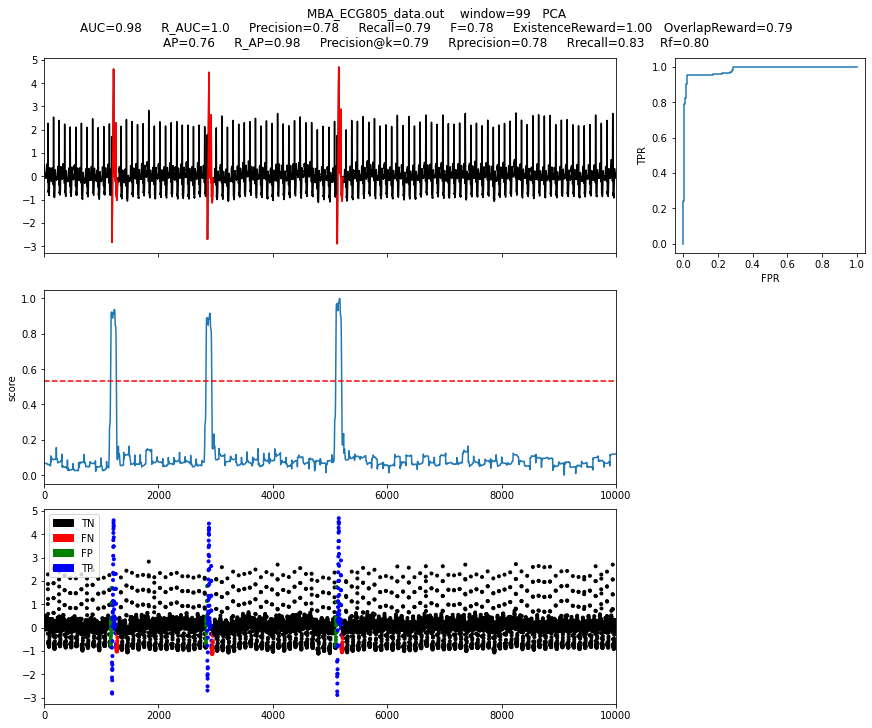

In [9]:
from TSB_UAD.models.pca import PCA

modelName='PCA'
clf = PCA()
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]
#plt.savefig('./'+modelName+'.png')

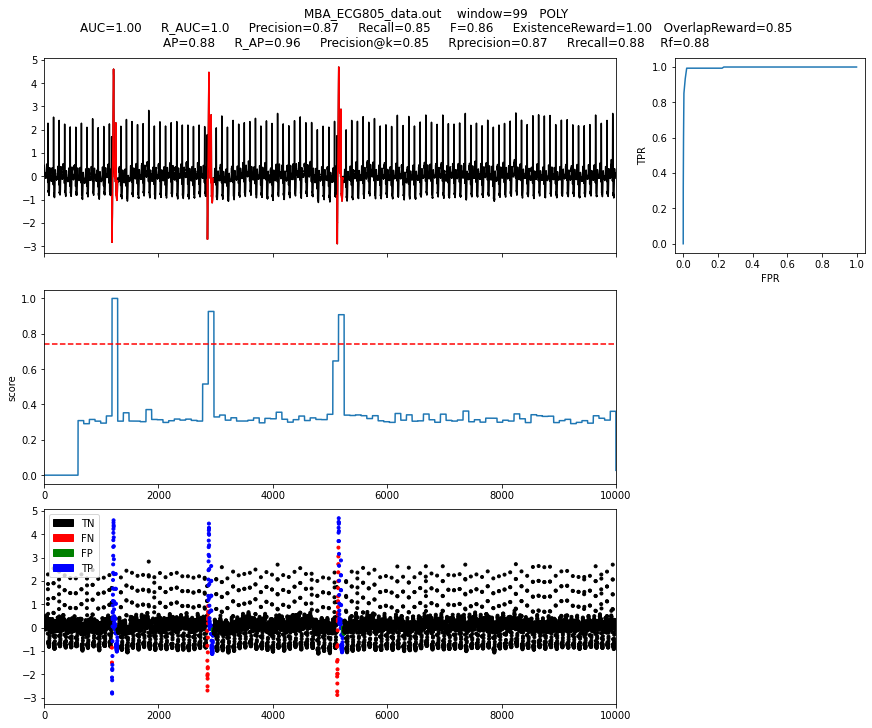

In [10]:
from TSB_UAD.models.poly import POLY

modelName='POLY'
clf = POLY(power=3, window = slidingWindow)
x = data
clf.fit(x)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]
#plt.savefig('./'+modelName+'.png')

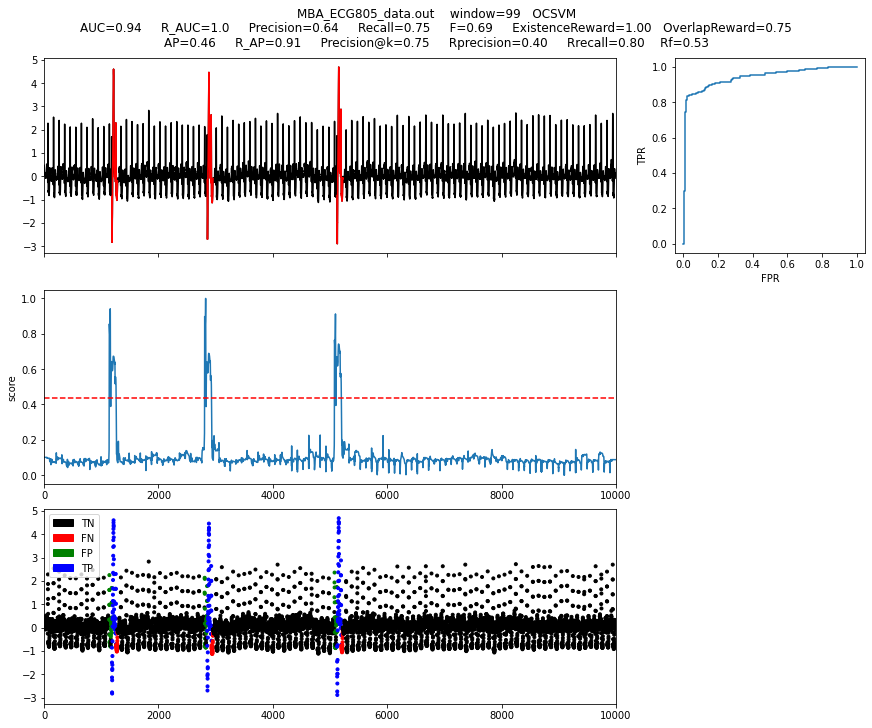

In [11]:
from TSB_UAD.models.ocsvm import OCSVM

modelName='OCSVM'
X_train_ = MinMaxScaler(feature_range=(0,1)).fit_transform(X_train.T).T
X_test_ = MinMaxScaler(feature_range=(0,1)).fit_transform(X_test.T).T

clf = OCSVM(nu=0.05)
clf.fit(X_train_, X_test_)


score = clf.decision_scores_
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]
#plt.savefig('./'+modelName+'.png')

310/310 [==============================] - 9s 24ms/step


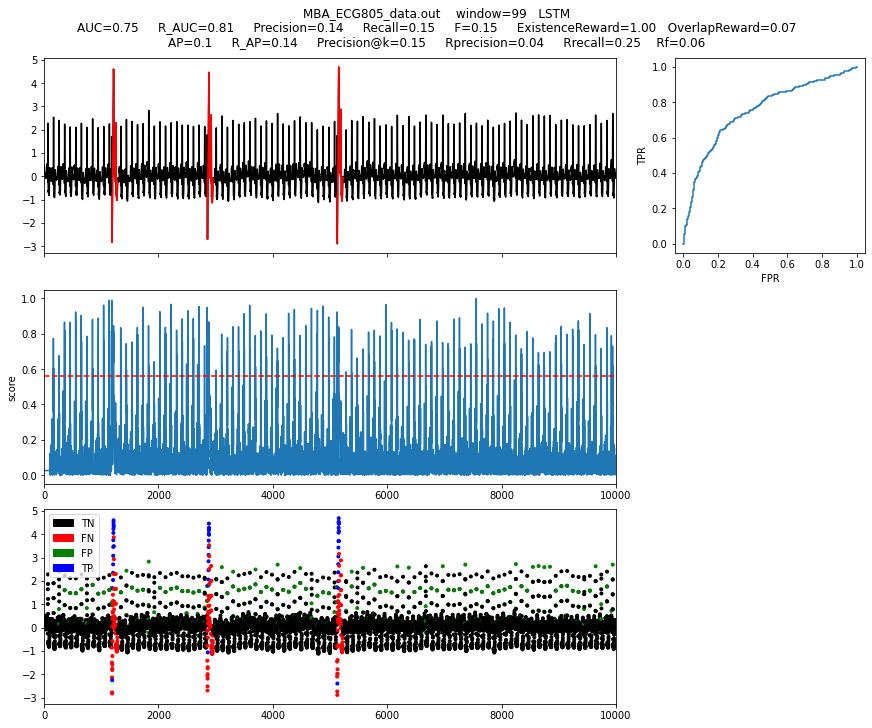

In [12]:
from TSB_UAD.models.lstm import lstm

modelName='LSTM'
clf = lstm(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 50, patience = 5, verbose=0)
clf.fit(data_train, data_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]
#plt.savefig('./'+modelName+'.png')

310/310 [==============================] - 1s 3ms/step


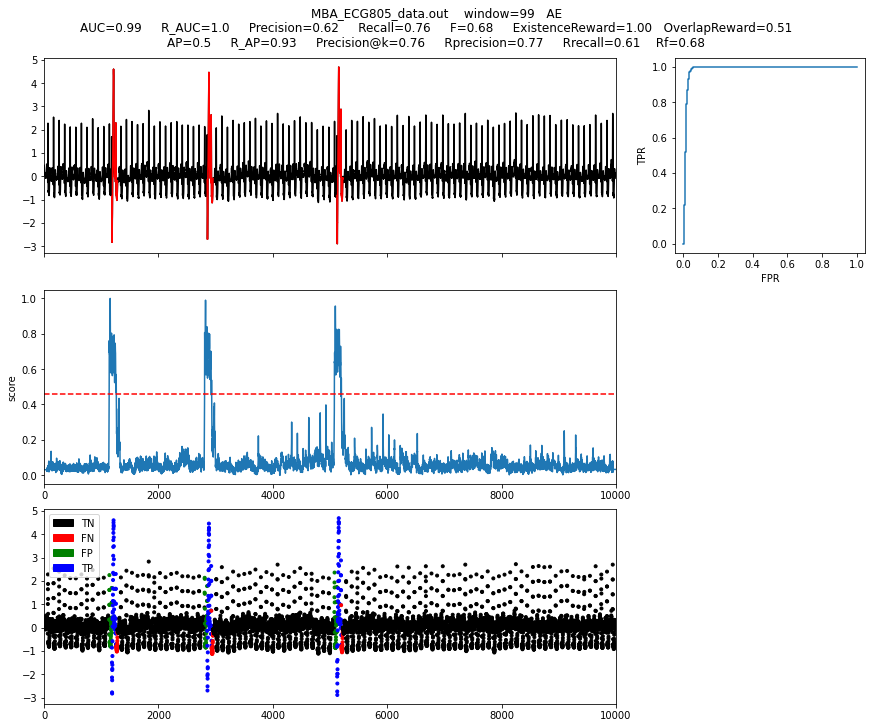

In [13]:
from TSB_UAD.models.AE_mlp2 import AE_MLP2

modelName='AE'
clf = AE_MLP2(slidingWindow = slidingWindow, epochs=100, verbose=0)

clf.fit(data_train, data_test)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]
#plt.savefig('./'+modelName+'.png')

310/310 [==============================] - 1s 4ms/step


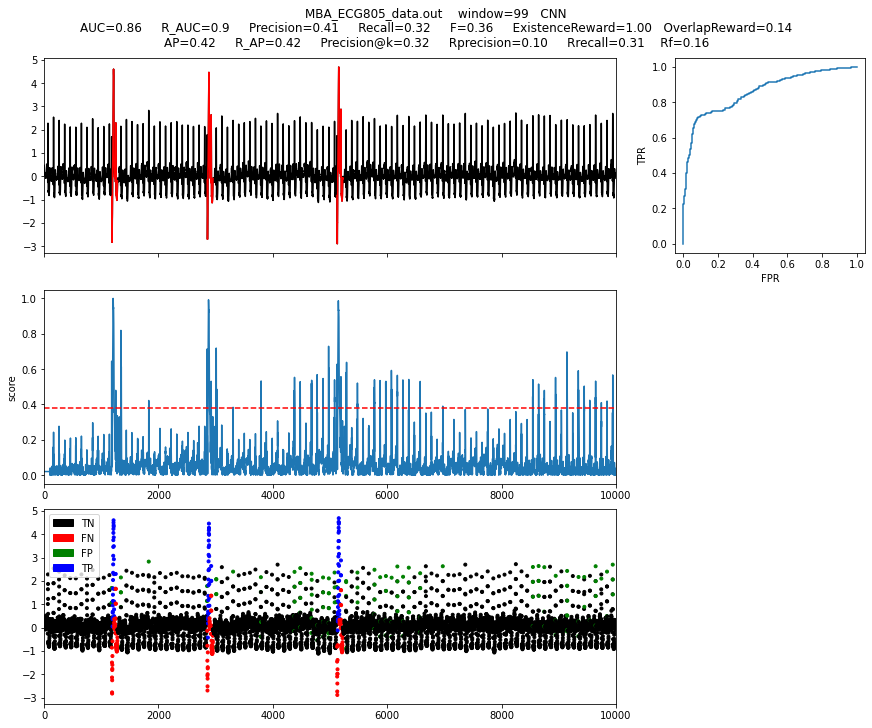

In [14]:
from TSB_UAD.models.cnn import cnn
modelName='CNN'
clf = cnn(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 100, patience = 5, verbose=0)

clf.fit(data_train, data_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]
#plt.savefig('./'+modelName+'.png')